# Playing with Coronavirus Timeseries

- https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset


## To Do:

- [ ] Add data from Covid Tracking Project's API
    - https://covidtracking.com/api
    
- [ ] Move app styling to a css file in a new `assets/` folder

### RESOURCES FOR FUTURE
- RAFAEL STUDY GROUP FOR MAKING A MAP
    - https://www.youtube.com/watch?v=MAhK7NHXEOg&feature=emb_logo
    - https://github.com/erdosn/additional-topic-plotly

In [1]:
import os,glob,sys
import re

In [2]:
!pip install -U fsds
from fsds.imports import *


Bad key "text.kerning_factor" on line 4 in
/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


fsds v0.2.15 loaded.  Read the docs: https://fs-ds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


[i] Pandas .iplot() method activated.


```python
## Determine if dataset is downloaded via Kaggle CLI
import os
from zipfile import ZipFile


if DOWNLOAD:
    !pip install kaggle --upgrade

    cmd = 'kaggle datasets download -d sudalairajkumar/novel-corona-virus-2019-dataset'
    os.system(cmd)
    print('Downloaded dataset Zipfie, extracting...')
    with ZipFile('novel-corona-virus-2019-dataset.zip') as file:
        file.extractall()
```

# Function-izing Processing

1. `download_coronavirus_data(fpath='New Data/)` 
2. `1oad_raw_df(filepaths[4])`
3. `get_and_clean_US`
4. `set_datetime_index`

# Main Kaggle Dataset - Get US States

### def  `download_coronavirus_data`

In [3]:
# @add_method(CoronaData)
def download_coronavirus_data(path='New Data/',verbose=False):
    """Installs the Kaggle Command Line Interface to clone dataset.
    Then extracts dataset to specified path and displays name of main file.
    Args:
        path(str): Folder to extract dataset into (must end with a '/')
        
    Returns:
        file_list(list): List of full filepaths to downloaded csv files.
    """
    ## Determine if dataset is downloaded via Kaggle CL
    import os,glob
    from zipfile import ZipFile
    from IPython.display import clear_output
    os.makedirs(path, exist_ok=True)

    ## Install Kaggle 
    !pip install kaggle --upgrade
    clear_output()
    
    ## Run Kaggle Command 
    cmd = 'kaggle datasets download -d sudalairajkumar/novel-corona-virus-2019-dataset'
    os.system(cmd)
    
    ## Extract ZipFile
    print(f'Downloaded dataset Zipfie, extracting to {path}...')
    zip_filepath = 'novel-corona-virus-2019-dataset.zip'
    with ZipFile(zip_filepath) as file:
        file.extractall(path)
    
    ## Delete Zip File
    os.system(f"rm {zip_filepath}"  )
    
    
    ## Get list of all csvs
    print('[i] Extraction Complete.')    
    file_list = glob.glob(path+"*.csv")
    
    
    ## Find main df 
    main_file = [file for file in file_list if 'covid_19_data.csv' in file]
    if verbose:
        print(f"[i] The main file name is {main_file}")
    return main_file[0] #file_list[index]

In [4]:
DOWNLOAD = True

if DOWNLOAD:
    main_file = download_coronavirus_data()
    print('\n\n[i] Success. Downloaded dataset from kaggle...')

else:
    print('Using pre-existing data')

Downloaded dataset Zipfie, extracting to New Data/...
[i] Extraction Complete.


[i] Success. Downloaded dataset from kaggle...


# 📦class `CoronaData`

In [5]:
def add_method(cls):
    from functools import wraps # This convenience func preserves name and docstring

    """source=https://medium.com/@mgarod/dynamically-add-a-method-to-a-class-in-python-c49204b85bd6"""
    def decorator(func):
        @wraps(func) 
        def wrapper(self, *args, **kwargs): 
            return func(*args, **kwargs)
        setattr(cls, func.__name__, wrapper)
        # Note we are not binding func, but wrapper which accepts self but does exactly the same as func
        return func # returning func means func can still be used normally
    return decorator


In [46]:
#Make a base class
class BaselineData(object):
    import pandas as pd
    _df = pd.DataFrame()

    @property
    def df(self):
        if hasattr(self,'_df_type'):
            print(self._df_type)
        if hasattr(self,'_df'):
            return self._df.copy()
        else:
            return None
        

    @df.setter 
    def df(self,value):
        self._df = value
        
        
    def get_group_ts(self,group_name,group_col='state',
                     ts_col=None,df=None,
                     freq='D', agg_func='sum'):
        """Take df_us and extracts state's data as then Freq/Aggregation provided"""
        ## 
        if df is None:
            df = self._df.copy()
            
        try:
            ## Get state_df group
            group_df = df.groupby(group_col).get_group(group_name)#.resample(freq).agg(agg)
        except Exception:
            display(df.head())
            return None
        ## Resample and aggregate state data
        group_df = group_df.resample(freq).agg(agg_func)


        ## Get and Rename Sum Cols 
        orig_cols = group_df.columns

        ## Create Renamed Sum columns
        for col in orig_cols:
            group_df[f"{group_name} - {col}"] = group_df[col]

        ## Drop original cols
        group_df.drop(orig_cols,axis=1,inplace=True)

        if ts_col is not None:
            ts_cols_selected = [col for col in group_df.columns if ts_col in col]
            group_df = group_df[ts_cols_selected]

        return group_df 
        

    ### CLASS DISPLAY RELATED ITEMS
    def _self_report(self,private=False,
                     methods=True,attributes=True,
                    workflow=False):
        import inspect
        attr_list = inspect.getmembers(self)
        dashes='---'*20
        report = [dashes]
        report.append("[i] CovidTrackingProject Contents:\n"+dashes)


        method_list=["\nMETHODS:"]
        attribute_list=["\nATTRIBUTES"]
        workflow_list = ["\nWORKFLOW:"]
        
        if private==False:
            startswithcheck = '_'
        else:
            startswithcheck ='__'
        
        ## Loop through all attr
        for item in attr_list:
            item_name = item[0]
            
            ## Exclude Private/Special Attrs
            if item_name.startswith(startswithcheck)== False:
                
                ## Get tf if item is method
                method_check = inspect.ismethod(item[1])
                
                ## If item is a method:
                if method_check==True:
                    method_list.append(item_name)
                ## If item is an attribute
                else: 
                    attribute_list.append(item_name) 
                    
        if workflow:
            ## Get workflow
            workflow_funcs = [self.download_coronavirus_data,
                             self.load_raw_df, self.get_and_clean_US]
            for i,method in enumerate(workflow_funcs):
                workflow_list.append(f"{i+1}. {method.__name__}")

            report.append('\n\t'.join(workflow_list))
        
        if methods:
            report.append('\n\t'.join(method_list))
        if attributes:
            report.append('\n\t'.join(attribute_list))
            
        return '\n'.join(report)
    
    
    def __str__(self):
        return self._self_report()
    
    def __repr__(self):
        return self._self_report()      
    

In [7]:
base = BaselineData()
base.df 
# get_group_ts('ny')

""


In [8]:
class CoronaData(BaselineData):

    def __init__(self,data_dir='New Data/',run_workflow=True,
                 download=True,verbose=True):
        
        ## Save params for later
        self.__download = download
        self.__verbose = verbose
        self._data_folder = data_dir
        
        ## Download data or set local filepath
        if download:
#             print("[i] DOWNLOADING DATA FROM KAGGLE:")
            self.download_coronavirus_data(verbose=verbose)
            
        else:
            self.get_data_fpath(data_dir)
        
        
        
        ## Load df_raw and df
        self.load_raw_df(verbose=verbose)
        
        ## Prepare State Data
        if run_workflow:
            self.get_and_clean_US()
            self._make_state_dict()
#             print('\n[!] Full Worfklow Complete:')
#             print('\tself.STATES, self.df_us created.')
            

    # @add_method(CoronaData)
    def download_coronavirus_data(self,path=None,verbose=None):
        """Installs the Kaggle Command Line Interface to clone dataset.
        Then extracts dataset to specified path and displays name of main file.
        Args:
            path(str): Folder to extract dataset into (must end with a '/')

        Returns:
            file_list(list): List of full filepaths to downloaded csv files.
        """        
        if verbose==None:
            verbose = self.__verbose
            
        if verbose:
            print('[i] DOWNLOADING DATA USING KAGGLE API')
            print("\thttps://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset")

        if path is None:
            path = self._data_folder
                                  
        ## Determine if dataset is downloaded via Kaggle CL
        import os,glob
        from zipfile import ZipFile
        from IPython.display import clear_output
        os.makedirs(path, exist_ok=True)

        try:
            import kaggle
        except:
            ## Install Kaggle 
            !pip install kaggle --upgrade
            clear_output()
            if verbose: print('\t- Installed kaggle command line tool.')

        ## Run Kaggle Command 
        cmd = 'kaggle datasets download -d sudalairajkumar/novel-corona-virus-2019-dataset'
        os.system(cmd)

        ## Extract ZipFile
        zip_filepath = 'novel-corona-virus-2019-dataset.zip'
        with ZipFile(zip_filepath) as file:
            file.extractall(path)
            
        if self.__verbose:
            print(f'\t- Downloaded dataset .zip and extracted to:"{path}"')
     
        ## Delete Zip File
        os.system(f"rm {zip_filepath}"  )
            
        self.get_data_fpath(path)

        
    def get_data_fpath(self,path):
        """save self._file_list and self._main_file"""
        import glob
        verbose = self.__verbose
        ## Get list of all csvs
        if verbose: print('\t- Extraction Complete.')    
        file_list = glob.glob(path+"*.csv")

        ## Find main df 
        main_file = [file for file in file_list if 'covid_19_data.csv' in file]
#         if verbose: print(f"- The main file name is {main_file}")
        self._file_list = file_list
        self._main_file = main_file[0]
    
    
    
    def load_raw_df(self,fpath=None,kws={},verbose=True):
        """Performs most basic of preprocessing, including renaming date column to 
        Date and dropping 'Last Update', and 'SNo' columns"""
        import pandas as pd
        if fpath is None:
            fpath = self._main_file

        ## Default Kws
        read_kws = dict(parse_dates=['ObservationDate','Last Update'])

        ## Add User kws
        read_kws = {**read_kws,**kws}

#         if verbose:
#             print(f"[i] Loading {fpath} with read_csv kws:",end='')
#             display(read_kws)

        ## Read in csv and save as self.df_raw
        df = pd.read_csv(fpath,**read_kws)
        self.df_raw = df.copy()
        ## Drop unwated columns
        df.drop(['Last Update',
                 'SNo'],axis=1,inplace=True)
        

        ## Rename Date columns
        df.rename({'ObservationDate':'Date'},axis=1,inplace=True)

        ## Display some info 
        if verbose:
            display(df.head())
            # Countries in the dataset
            print(f"[i] There are "+str(len(df['Country/Region'].unique()))+" countries in the datatset")

            ## Get first and last date
            start_ts = df["Date"].loc[df['Date'].idxmin()].strftime('%m-%d-%Y')
            end_ts = df["Date"].loc[df['Date'].idxmax()].strftime('%m-%d-%Y')
            # DF['Date'].idxmin(), DF['Date'].idxmax()
            print(f"[i] Dates Covered:\n\tFrom {start_ts} to {end_ts}")

        self._df = df.copy()#self.set_datetime_index(df)
        
        
        
    
    def set_datetime_index(self,df_=None,col='Date'):#,drop_old=False):
        """Returns df with specified column as datetime index"""
        import pandas as pd

        ## Grab df from self if None
        if df_ is None:
            df_ = self.df
            
        ## Copy to avoid edits to orig
        df = df_.copy()
        
        ## Convert to date time
        df[col] = pd.to_datetime(df[col],infer_datetime_format=True)
        
        ## Set as index
        df.set_index(df[col],drop=True,inplace=True)
        
        # Drop the column if it is present
        if col in df.columns:
            df.drop(columns=col,inplace=True)
            
        return df
    
    
    
    def load_us_reference_info(self):
        """Return and save US Reference Data"""
        ## Making Master Lookup CSV
        import pandas as pd
        abbrev = pd.read_csv('Reference Data/united_states_abbreviations.csv')
        pop = pd.read_csv('Reference Data/us-pop-est2019-alldata.csv')
        us_pop = pop.loc[pop['STATE']>0][['NAME','POPESTIMATE2019']].copy()
        us_info = pd.merge(abbrev,us_pop,right_on='NAME',left_on='State',how="inner")
        us_info.drop('NAME',axis=1,inplace=True)
        self.reference_data = us_info
        return us_info
    
    
    def calculate_per_capita(self,df_=None,stat_cols = ['Confirmed','Deaths','Recovered']):
        """Calculate Per Capita columns"""
        if df_ is None:
            df_ = self.df
            
        df = df_.copy()
        
        if 'POPESTIMATE2019' in df.columns==False:
            self.load_us_reference_info()
            
        ## ADDING PER CAPITA DATA 
        for col in stat_cols:
            df[f"{col} Per Capita"] = df[col]/df['POPESTIMATE2019']
        df.drop('POPESTIMATE2019',axis=1,inplace=True)
        return df    

    
    
    def get_and_clean_US(self,df=None,#save_as = 'Reference Data/united_states_abbreviations.csv',
                         make_date_index=True,per_capita=True):
        """Takes raw df loaded and extracts United States and processes
        all state names to create new abbreviation column 'state'.
        """
        import pandas as pd
        if df is None:
            df= self._df.copy()
            
        ## Get only US
        df_us = df.groupby('Country/Region').get_group('US').copy() 
        state_lookup = self.load_us_reference_info()


        ## Make renaming dict for states
        STATE_DICT = dict(zip(state_lookup['State'],state_lookup['Abbreviation']))
        STATE_DICT.update({'Chicago':'IL',
                          'Puerto Rico':'PR',
                          'Virgin Islands':'VI',
                          'United States Virgin Islands':'VI'})

        ## Separately Process Rows that contain a city, state 
        df_city_states = df_us[df_us['Province/State'].str.contains(',')]


        ## Finding City Abbreviations in city_states
        import re
        state_expr = re.compile(r"[A-Z\.]{2,4}")
        df_city_states['state'] = df_city_states['Province/State'].apply(state_expr.findall)
        df_city_states = df_city_states.explode('state')


        ## Seperately process Rows that do not contain a city,state
        df_states = df_us[~df_us['Province/State'].str.contains(',')]
        df_states['state'] =  df_states['Province/State'].map(STATE_DICT)

        ## Combining data frame back together
        df = pd.concat([df_states,df_city_states]).sort_index()
#         df = df.dropna(subset=['state'])

        ## Fix some stragglers (like D.C. vs DC)
        df['state'] = df['state'].replace('D.C.','DC')
        
        ## Combine Cleaned Data 
        df = pd.merge(df, state_lookup,left_on='state',right_on="Abbreviation")
        
        df.rename({'State':'State Name'},inplace=True,axis=1)
        df.drop(columns=['Abbreviation','State Name'],inplace =True)
        
    
        ## Add Population Data
        if per_capita:

            for col in  ['Confirmed','Deaths','Recovered']:
                df[f"{col} Per Capita"] = df[col]/df['POPESTIMATE2019']

            ## Remove Population 
            df.drop('POPESTIMATE2019',axis=1,inplace=True)

        if make_date_index:
            df = self.set_datetime_index(df)
        
#         df.drop(columns=['Province/State'],inplace=True)

        self.df_us = df.copy()
#         self.US = df.copy()
        return df
    
    
#     def get_state_ts(self,state_name,df=None,
#                      group_col='state', ts_col=None,
#                      freq='D', agg_func='sum'):
#         """Take df_us and extracts state's data as then Freq/Aggregation provided"""
#         ## 
#         if df is None:
#             df = self.df_us.copy()
            
            
#         ## Get state_df group
#         state_df = df.groupby(group_col).get_group(state_name)#.resample(freq).agg(agg)

#         ## Resample and aggregate state data
#         state_df = state_df.resample(freq).agg(agg_func)


#         ## Get and Rename Sum Cols 
#         orig_cols = state_df.columns

#         ## Create Renamed Sum columns
#         for col in orig_cols:
#             state_df[f"{state_name} - {col}"] = state_df[col]

#         ## Drop original cols
#         state_df.drop(orig_cols,axis=1,inplace=True)

#         if ts_col is not None:
#             ts_cols_selected = [col for col in state_df.columns if ts_col in col]
#             state_df = state_df[ts_cols_selected]

#         return state_df 

    
    def _make_state_dict(self,df=None,col='state'):
        if df is None:
            df = self.df_us.copy()
            
        elif col not in df.columns:
            msg = f"{col} not in df.columns.\nColumns include:"+'\n'.join(df.columns)
            raise Exception(msg)
            
        state_list=df[col].unique()

        STATES = {}
        for state in state_list:
            STATES[state] = self.get_group_ts(state,df=df)
        self.STATES = STATES

        
        

In [9]:
corona = CoronaData(verbose=True,run_workflow=True)
# print(corona)

corona.df

[i] DOWNLOADING DATA USING KAGGLE API
	https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset
	- Downloaded dataset .zip and extracted to:"New Data/"
	- Extraction Complete.


,Date,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,2020-01-22,Anhui,Mainland China,1.0,0.0,0.0
1,2020-01-22,Beijing,Mainland China,14.0,0.0,0.0
2,2020-01-22,Chongqing,Mainland China,6.0,0.0,0.0
3,2020-01-22,Fujian,Mainland China,1.0,0.0,0.0
4,2020-01-22,Gansu,Mainland China,0.0,0.0,0.0


[i] There are 223 countries in the datatset
[i] Dates Covered:
	From 01-22-2020 to 06-30-2020


,Date,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,2020-01-22,Anhui,Mainland China,1.0,0.0,0.0
1,2020-01-22,Beijing,Mainland China,14.0,0.0,0.0
2,2020-01-22,Chongqing,Mainland China,6.0,0.0,0.0
3,2020-01-22,Fujian,Mainland China,1.0,0.0,0.0
4,2020-01-22,Gansu,Mainland China,0.0,0.0,0.0
...,...,...,...,...,...,...
53922,2020-06-30,Zacatecas,Mexico,908.0,96.0,626.0
53923,2020-06-30,Zakarpattia Oblast,Ukraine,2889.0,91.0,943.0
53924,2020-06-30,Zaporizhia Oblast,Ukraine,572.0,17.0,418.0
53925,2020-06-30,Zhejiang,Mainland China,1269.0,1.0,1267.0


In [10]:
corona.get_and_clean_US()
corona.df_us

,Province/State,Country/Region,Confirmed,Deaths,Recovered,state,Confirmed Per Capita,Deaths Per Capita,Recovered Per Capita
Date,,,,,,,,,
2020-01-22,Washington,US,1.0,0.0,0.0,WA,1.313216e-07,0.000000,0.0
2020-01-23,Washington,US,1.0,0.0,0.0,WA,1.313216e-07,0.000000,0.0
2020-01-24,Washington,US,1.0,0.0,0.0,WA,1.313216e-07,0.000000,0.0
2020-01-25,Washington,US,1.0,0.0,0.0,WA,1.313216e-07,0.000000,0.0
2020-01-26,Washington,US,1.0,0.0,0.0,WA,1.313216e-07,0.000000,0.0
...,...,...,...,...,...,...,...,...,...
2020-06-26,Puerto Rico,US,6922.0,151.0,0.0,PR,2.167396e-03,0.000047,0.0
2020-06-27,Puerto Rico,US,7066.0,152.0,0.0,PR,2.212485e-03,0.000048,0.0
2020-06-28,Puerto Rico,US,7189.0,153.0,0.0,PR,2.250998e-03,0.000048,0.0


In [11]:
corona.df_us

,Province/State,Country/Region,Confirmed,Deaths,Recovered,state,Confirmed Per Capita,Deaths Per Capita,Recovered Per Capita
Date,,,,,,,,,
2020-01-22,Washington,US,1.0,0.0,0.0,WA,1.313216e-07,0.000000,0.0
2020-01-23,Washington,US,1.0,0.0,0.0,WA,1.313216e-07,0.000000,0.0
2020-01-24,Washington,US,1.0,0.0,0.0,WA,1.313216e-07,0.000000,0.0
2020-01-25,Washington,US,1.0,0.0,0.0,WA,1.313216e-07,0.000000,0.0
2020-01-26,Washington,US,1.0,0.0,0.0,WA,1.313216e-07,0.000000,0.0
...,...,...,...,...,...,...,...,...,...
2020-06-26,Puerto Rico,US,6922.0,151.0,0.0,PR,2.167396e-03,0.000047,0.0
2020-06-27,Puerto Rico,US,7066.0,152.0,0.0,PR,2.212485e-03,0.000048,0.0
2020-06-28,Puerto Rico,US,7189.0,153.0,0.0,PR,2.250998e-03,0.000048,0.0


In [12]:
# corona.US

In [13]:
corona.df.head(2)

,Date,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,2020-01-22,Anhui,Mainland China,1.0,0.0,0.0
1,2020-01-22,Beijing,Mainland China,14.0,0.0,0.0


In [16]:
corona.df_us.head(2)

,Province/State,Country/Region,Confirmed,Deaths,Recovered,state,Confirmed Per Capita,Deaths Per Capita,Recovered Per Capita
Date,,,,,,,,,
2020-01-22,Washington,US,1.0,0.0,0.0,WA,1.313216e-07,0.0,0.0
2020-01-23,Washington,US,1.0,0.0,0.0,WA,1.313216e-07,0.0,0.0


In [17]:
md = corona.get_group_ts('MD')
md

,Date,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,2020-01-22,Anhui,Mainland China,1.0,0.0,0.0
1,2020-01-22,Beijing,Mainland China,14.0,0.0,0.0
2,2020-01-22,Chongqing,Mainland China,6.0,0.0,0.0
3,2020-01-22,Fujian,Mainland China,1.0,0.0,0.0
4,2020-01-22,Gansu,Mainland China,0.0,0.0,0.0


In [18]:
df = corona.df_us.copy()

## Report Total Cases
total_cases = df.groupby('state').sum()[['Confirmed','Deaths']]
total_cases.sort_values('Confirmed',0,0).head(20).style.bar(['Deaths','Confirmed'])

,Confirmed,Deaths
state,,
NY,28942643.000000,2188197.000000
NJ,11761973.000000,803047.000000
CA,8262701.000000,284372.000000
IL,7642585.000000,347153.000000
MA,6757963.000000,442423.000000
PA,5349612.000000,350154.000000
TX,4998425.000000,113353.000000
FL,4736081.000000,169172.000000
MI,4391352.000000,388459.000000


# Install/Import plotly,etc

In [19]:
# !pip install plotly-geo==1.0.0

In [20]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_dark"

import cufflinks as cf
cf.go_offline()
cf.set_config_file(sharing='public',theme='solar',offline=True)


### Plot selected states and columns

In [21]:
STATES = corona.STATES

In [22]:
### Define states and columns to plot
plot_states = ['NY','MD','CA']
plot_cols = ['Confirmed']

## Make empty list for states to concat
concat_dfs = []

# Grab each state's df
for state in plot_states:
    dfs = STATES[state]
    
    ## for each plot_cols, find all columns that contain that col name
    for plot_col in plot_cols:
        concat_dfs.append(dfs[[col for col in dfs.columns if plot_col in col]])

        
## Concatenate final dfs
plot_df = pd.concat(concat_dfs,axis=1)#[STATES[s] for s in plot_states],axis=1).iplot()

In [23]:
## Plot concatenated dfs
pfig = plot_df.iplot()#theme='solar',asFigure=True)
pfig

In [24]:
# help(cf.themes.THEMES)

In [25]:
# pio.templates['plotly_dark']

In [26]:
help(cf)

Help on package cufflinks:

NAME
    cufflinks

DESCRIPTION
    A productivity tool that binds pandas and plotly.
    Kudos to the Plotly team!
    
    Author: @jorgesantos

PACKAGE CONTENTS
    auth
    colors
    datagen
    date_tools
    exceptions
    extract
    helper
    offline
    pandastools
    plotlytools
    quant_figure
    ta
    themes
    tools
    utils
    version

DATA
    absolute_import = _Feature((2, 5, 0, 'alpha', 1), (3, 0, 0, 'alpha', 0...
    cnames = {'aliceblue': '#F0F8FF', 'antiquewhite': '#FAEBD7', 'aqua': '...

VERSION
    0.17.0

FILE
    /anaconda3/envs/learn-env/lib/python3.6/site-packages/cufflinks/__init__.py




# 📺 DASHBOARD

## FUNCTIONS

### `def get_state_ts`

In [27]:
def get_state_ts(df, state_name,
                     group_col='state', ts_col=None,
                     freq='D', agg_func='sum'):
    """Take df_us and extracts state's data as then Freq/Aggregation provided"""
    
    ## Get state_df group
    state_df = df.groupby(group_col).get_group(state_name)#.resample(freq).agg(agg)
    
    ## Resample and aggregate state data
    state_df = state_df.resample(freq).agg(agg_func)
    
    
    ## Get and Rename Sum Cols 
    orig_cols = state_df.columns

    ## Create Renamed Sum columns
    for col in orig_cols:
        state_df[f"{state_name} - {col}"] = state_df[col]
      
    ## Drop original cols
    state_df.drop(orig_cols,axis=1,inplace=True)
    
    
    ## Select columns from ts_cols
    if ts_col is not None:
        ts_cols_selected = [col for col in state_df.columns if ts_col in col]
        state_df = state_df[ts_cols_selected]

    return state_df

In [28]:
## Variable to control if dash app is run
RUN_APP = True 

**DASHBOARD FEATURES**
- Current Features:
    - Plotly Time Series Plot for US States
    
- TO DO Features:
    - Plotly Map of Cases by State/Zipcode

        - Time Series Plot by Zipcode

**FOR PLOTTING:**
- Need a plotly function that will allow for choices of data to display
- Plotting Function options:
    - Type of Cases: 
        - (confirmed, deaths,recovered)
        - Per Capita versions of above
    - Display New Cases or Cumulative Cases
    - 

### def `plot_states`

In [29]:
corona = CoronaData(download=True,verbose=False)#.get_state_ts('NY')

In [30]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_dark"

import cufflinks as cf
cf.go_offline()
cf.set_config_file(sharing='public',theme='solar',offline=True)


In [31]:
cf.themes.THEMES['solar']


{'colorscale': 'original',
 'linewidth': 1.3,
 'bargap': 0.01,
 'layout': {'legend': {'bgcolor': 'charcoal', 'font': {'color': 'pearl'}},
  'paper_bgcolor': 'charcoal',
  'plot_bgcolor': 'charcoal',
  'yaxis': {'tickfont': {'color': 'grey12'},
   'gridcolor': 'grey08',
   'titlefont': {'color': 'pearl'},
   'zerolinecolor': 'grey09',
   'showgrid': True},
  'xaxis': {'tickfont': {'color': 'grey12'},
   'gridcolor': 'grey08',
   'titlefont': {'color': 'pearl'},
   'zerolinecolor': 'grey09',
   'showgrid': True},
  'titlefont': {'color': 'pearl'}},
 'annotations': {'fontcolor': 'pearl', 'arrowcolor': 'grey11'}}

### def `plot_states`

In [32]:
def plot_states(df, state_list, plot_cols = ['Confirmed'],df_only=False,
                new_only=False,plot_scatter=True,show=False):
    """Plots the plot_cols for every state in state_list.
    Returns plotly figure
    New as of 06/21"""
    
    ## Get state dataframes
    concat_dfs = []  
    STATES = {}
    
    ## Get each state
    for state in state_list:

        # Grab each state's df and save to STATES
        dfs = get_state_ts(df,state)
        STATES[state] = dfs

        ## for each plot_cols, find all columns that contain that col name
        for plot_col in plot_cols:
            concat_dfs.append(dfs[[col for col in dfs.columns if col.endswith(plot_col)]])#plot_col in col]])

    ## Concatenate final dfs
    plot_df = pd.concat(concat_dfs,axis=1)#[STATES[s] for s in plot_states],axis=1).iplot()
    
    
    ## Set title and df if new_only
    if new_only:
        plot_df = plot_df.diff()
        title = "Coronavirus Cases by State - New Cases"
    else:
        title = 'Coronavirus Cases by State - Cumulative'
    
    ## Reset Indes
    plot_df.reset_index(inplace=True)
    
    
    ## Return Df or plot
    if df_only==False:

        if np.any(['per capita' in x.lower() for x in plot_cols]):
            value_name = "# of Cases - Per Capita"
        else:
            value_name='# of Cases'
        pfig_df_melt = plot_df.melt(id_vars=['Date'],var_name='State',
                                    value_name=value_name)
        
        if plot_scatter:
            plot_func = px.scatter
        else:
            plot_func = px.line
            
            
        # Plot concatenated dfs
        pfig = plot_func(pfig_df_melt,x='Date',y=value_name,color='State',
                      width=800,height=500,title=title,template='plotly_dark')
        
#         pfig.update_xaxes(rangeslider_visible=True)

                # Add range slider
        pfig.update_layout(
            xaxis=dict(
                rangeselector=dict(
                    buttons=list([
                        dict(count=7,
                             label="1week",
                             step="day",
                             stepmode="backward"),
                        dict(count=14,
                             label="2weeks",
                             step="day",
                             stepmode="backward"),
                        dict(count=1,
                             label="1m",
                             step="month",
                             stepmode="backward"),
                        dict(count=6,
                             label="6m",
                             step="month",
                             stepmode="backward"),

                        dict(step="all")
                    ])
                ),
                rangeslider=dict(
                    visible=True
                ),
                type="date"
            )
        )
        
        if show:
            pfig.show()
            
        return pfig
    else:
        return plot_df#.reset_index()
    

In [33]:
## Using Function
pfig = plot_states(df,['NY','MD','KY','CA','FL','MA','DC','VA'],
                  plot_cols=['Confirmed'],plot_scatter=True)#,new_only=True)#,df_only=True)
pfig

In [34]:
# ## Using Function
# pfig = plot_states(df,['NY','MD','KY','CA','FL','MA','DC','VA'],
#                   plot_cols=['Confirmed','Deaths'],df_only=True)
# pfig.melt(id_vars=['Date'],var_name='State',
#                                     value_name='# of Cases')
#         Plot concatenated dfs


# pfig_df = plot_states(df,['NY','MD','DC','CA','FL','TX'],
#                       plot_cols=['Confirmed'],
#                       df_only=True)
# # display(pfig_df.head(5)) 

# pfig_df.diff()

# pfig_df_melt = pfig_df.melt(id_vars=['Date'],var_name='State',value_name='# of Cases')
# pfig_df_melt

# pfig = px.scatter(pfig_df_melt,x='Date',y='# of Cases',color='State')
# pfig

# pfig_df = plot_states(df,['NY','MD','KY','CA','FL'],plot_cols=['Confirmed','Deaths'],
          
#                       df_only=True)
# pfig_df.head()

## APP

### Load Dashboard Data

In [35]:
## RUN FULL WORKFLOW
corona_data = CoronaData(verbose=True,download=True,run_workflow=True)
df = corona_data.df_us.copy()
display(df.head())

[i] DOWNLOADING DATA USING KAGGLE API
	https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset
	- Downloaded dataset .zip and extracted to:"New Data/"
	- Extraction Complete.


,Date,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,2020-01-22,Anhui,Mainland China,1.0,0.0,0.0
1,2020-01-22,Beijing,Mainland China,14.0,0.0,0.0
2,2020-01-22,Chongqing,Mainland China,6.0,0.0,0.0
3,2020-01-22,Fujian,Mainland China,1.0,0.0,0.0
4,2020-01-22,Gansu,Mainland China,0.0,0.0,0.0


[i] There are 223 countries in the datatset
[i] Dates Covered:
	From 01-22-2020 to 06-30-2020


,Province/State,Country/Region,Confirmed,Deaths,Recovered,state,Confirmed Per Capita,Deaths Per Capita,Recovered Per Capita
Date,,,,,,,,,
2020-01-22,Washington,US,1.0,0.0,0.0,WA,1.313216e-07,0.0,0.0
2020-01-23,Washington,US,1.0,0.0,0.0,WA,1.313216e-07,0.0,0.0
2020-01-24,Washington,US,1.0,0.0,0.0,WA,1.313216e-07,0.0,0.0
2020-01-25,Washington,US,1.0,0.0,0.0,WA,1.313216e-07,0.0,0.0
2020-01-26,Washington,US,1.0,0.0,0.0,WA,1.313216e-07,0.0,0.0


In [36]:
corona_data

------------------------------------------------------------
[i] CovidTrackingProject Contents:
------------------------------------------------------------

METHODS:
	calculate_per_capita
	download_coronavirus_data
	get_and_clean_US
	get_data_fpath
	get_group_ts
	load_raw_df
	load_us_reference_info
	set_datetime_index

ATTRIBUTES
	STATES
	df
	df_raw
	df_us
	pd
	reference_data

### JupyterDash app

In [37]:
import plotly.io as pio
# pio.

In [38]:
try:
    from jupyter_dash import JupyterDash
except:
    %conda install -c conda-forge -c plotly jupyter-dash
    from jupyter_dash import JupyterDash

## IMPORTS
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go


import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output


def make_options(menu_choices):
    """Returns list of dictionary with {'label':menu_choice,'value':menu_choice}"""
    options = []
    for choice in menu_choices:
        options.append({'label':choice,'value':choice})
    return options

## Make Plot Cols list for options
stat_cols = ['Confirmed','Deaths','Recovered']
plot_cols = []
for column in stat_cols:
    plot_cols.extend([col for col in df.columns if column in col])

new_options = [{'label':'New Cases Only','value':1},
{'label':'Cumulative Cases','value':0}]



# Build App
app = JupyterDash(name='corona',external_stylesheets=['assets/my_style.css'])

app.layout = html.Div(
    id='app',
    children=[
        html.H1("Coronavirus Analysis"),
        html.H2("Select Case Types and States"),
        html.Div(id="menu",
                 children=[
                     html.Div(id='case_type_menu', 
                              children=[
                                  dcc.RadioItems(id='choose_new',
                                                 options=new_options,
                                                 value=0),
                                  dcc.Dropdown(id='choose_cases',multi=False,
                                               placeholder='Select Case Type', 
                                               options=make_options(plot_cols),
                                               value='Confirmed')]),
                     dcc.Dropdown(id='choose_states',
                                  multi=True,
                                  placeholder='Select States', 
                                  options= make_options(df['state'].sort_values().unique( )),
                                  value=['MD','NY','TX','CA','AZ'])
                 ]),
        dcc.Graph(id='graph')
    ])



@app.callback(Output('graph','figure'),[Input('choose_states','value'),
                                       Input('choose_cases','value'),
                                       Input('choose_new','value')])
def update_output_div(states,cases,new_only):
    if isinstance(states,list)==False:
        states = [states]
    if isinstance(cases,list)==False:
        cases = [cases]

    pfig = plot_states(df,states,plot_cols=cases,new_only=new_only)
    return pfig


if RUN_APP:
    app.run_server(mode='external')
else:
    print('[!] Did not initialize Dash app since RUN_APP==False')

 * Tip: There are .env or .flaskenv files present. Do "pip install python-dotenv" to use them.


Dash app running on http://127.0.0.1:8050/


#  📕Covid Tracking Project Data

https://covidtracking.com/api

`/api/v1/states/{state}/screenshots.csv`

In [39]:
from fsds.imports import *

In [40]:
pd.set_option('display.max_columns',0)

### Get US Daily


In [41]:
import datetime as dt
import requests
import json,urllib
todays_date = dt.datetime.now().strftime('%m%d%Y')

base_url = f"http://covidtracking.com"
# state='ny'
# url = f"http://covidtracking.com/api/v1/states/{state}/screenshots.json"
us_daily_url = '/api/v1/us/daily.csv'
states_daily_url = '/api/v1/states/daily.csv'

## 📦 class `CovidTrackingProject`

In [45]:
# #Make a base class
# class BaselineData:
#     _df = pd.DataFrame()
    
#     @property
#     def df(self):
#         if hasattr(self,'_df_type'):
#             print(self._df_type)
#         if hasattr(self,'_df'):
#             return self._df.copy()
#         else:
#             return None
        

#     @df.setter 
#     def df(self,value):
#         self._df = value
    
#     def __str__(self):
#         return self._self_report()
    
#     def __repr__(self):
# #         print(self._self_report())
#         return self._self_report()  



#   ### CLASS DISPLAY RELATED ITEMS
#     def _self_report(self,private=False,
#                      methods=True,attributes=True,
#                     workflow=False):
#         import inspect
#         attr_list = inspect.getmembers(self)
#         dashes='---'*20
#         report = [dashes]
#         report.append("[i] CovidTrackingProject Contents:\n"+dashes)


#         method_list=["\nMETHODS:"]
#         attribute_list=["\nATTRIBUTES"]
#         workflow_list = ["\nWORKFLOW:"]
        
#         if private==False:
#             startswithcheck = '_'
#         else:
#             startswithcheck ='__'
        
#         ## Loop through all attr
#         for item in attr_list:
#             item_name = item[0]
            
#             ## Exclude Private/Special Attrs
#             if item_name.startswith(startswithcheck)== False:
                
#                 ## Get tf if item is method
#                 method_check = inspect.ismethod(item[1])
                
#                 ## If item is a method:
#                 if method_check==True:
#                     method_list.append(item_name)
#                 ## If item is an attribute
#                 else: 
#                     attribute_list.append(item_name) 
                    
#         if workflow:
#             ## Get workflow
#             workflow_funcs = [self.download_coronavirus_data,
#                              self.load_raw_df, self.get_and_clean_US]
#             for i,method in enumerate(workflow_funcs):
#                 workflow_list.append(f"{i+1}. {method.__name__}")

#             report.append('\n\t'.join(workflow_list))
        
#         if methods:
#             report.append('\n\t'.join(method_list))
#         if attributes:
#             report.append('\n\t'.join(attribute_list))
            
#         return '\n'.join(report)
        

In [47]:
base = BaselineData()
base

------------------------------------------------------------
[i] CovidTrackingProject Contents:
------------------------------------------------------------

METHODS:
	get_group_ts

ATTRIBUTES
	df
	pd

In [48]:
class CovidTrackingProject(BaselineData):
    base_url = f"http://covidtracking.com"
    data = dict()
    urls = dict(us = base_url+'/api/v1/us/daily.csv',
                states = base_url+'/api/v1/states/daily.csv',
                states_metadata = base_url+"/api/v1/states/info.csv"
               )
    
    ## Store good vs deprecated columns
    columns = dict(
        states = {'good':[
            'positive','negative','death','recovered',
            'hospitalizedCurrently','hospitalizedCumulative',
            'inIcuCurrently','inIcuCumulative',
            'onVentilatorCurrently','onVentilatorCumulative',
            "state", "pending", "dataQualityGrade", 
            "lastUpdateEt", "totalTestsViral", 
            "positiveTestsViral", "negativeTestsViral", 
            "positiveCasesViral", "fips", "positiveIncrease", 
            "totalTestResults", "totalTestResultsIncrease", 
            "deathIncrease", "hospitalizedIncrease"],
                  
                  'deprecated':[
                      'checkTimeEt','commercialScore',
                      'dateChecked','dateModified','grade',
                      'hash','hospitalized','negativeIncrease',
                      'negativeRegularScore','negativeScore',
                      'posNeg','positiveScore','score','total',
                  ]})
#     @property
    def help(self):
        print("\n[HELP] For more information, check the api documentation:")
        print("\thttps://covidtracking.com/api")
    
    
    
    def __init__(self,base_folder="New Data/",
                 download=True,verbose=True,df='states'):
        self.base_folder = base_folder
        self.__verbose = verbose
        
        
        if download:
            
            if self.__verbose:
                print(f"[i] DOWNLOADING DATASETS FROM COVID TRACKING PROJECT")
                print("\thttps://covidtracking.com/data")
            
            workflow = [self.download_state_meta,
             self.download_us_daily,self.download_state_daily]
            
            for method in workflow:
                try:
                    method()
                except:
                    print('ERROR')
            
        else:
            raise Exception("Non-download loading not implemented yet.")
        
        ## Set .df attribute
        if df.lower()=='states':
            self._df_type = df
            self._df = self.STATES[self.columns['states']['good']].copy()
        elif df.lower()=='us':
            self._df = self.US.copy()
        
        
    
    def get_csv_save_load(self,url, fpath,read_kws={'parse_dates':['date']}):
        import pandas as pd
        import requests
        response = requests.get(url).content
        
        with open(fpath,'wb') as file:
            file.write(response)

        state_meta = pd.read_csv(fpath,**read_kws)
        if self.__verbose:
            print(f'\t- File saved as: "{fpath}"')

        return state_meta
    
    
    
    def download_us_daily(self):
        key = 'us'
        data = self._download_data_key(key)
#         setattr(self,key,data)
        return data
        
        
    def download_state_daily(self):
        key = 'states'
        data = self._download_data_key(key)#,read_kws={})
#         setattr(self,key,data)
        return data
    
    def download_state_meta(self):
        
        key = 'states_metadata'
        data = self._download_data_key(key,read_kws={})
        
        return data
         

    
    def _download_data_key(self,key,read_kws={'parse_dates':['date'],
                                             'index_col':'date'}):
        #Fetch the corresponding url from self.urls"
        url = self.urls[key]
        
        ## Get and load csv
        data = self.get_csv_save_load(url,fpath=self.base_folder+key+'.csv',
                                      read_kws=read_kws)
        ## Save to data dictionary
        self.data[key] = data.copy()
        
        setattr(self,key.upper(),data)

        return data
    
        

In [49]:
covid=CovidTrackingProject(download=True,verbose=True)
covid

[i] DOWNLOADING DATASETS FROM COVID TRACKING PROJECT
	https://covidtracking.com/data
	- File saved as: "New Data/states_metadata.csv"
	- File saved as: "New Data/us.csv"
	- File saved as: "New Data/states.csv"
states


------------------------------------------------------------
[i] CovidTrackingProject Contents:
------------------------------------------------------------

METHODS:
	download_state_daily
	download_state_meta
	download_us_daily
	get_csv_save_load
	get_group_ts
	help

ATTRIBUTES
	STATES
	STATES_METADATA
	US
	base_folder
	base_url
	columns
	data
	df
	pd
	urls

In [50]:
covid.df

states


,positive,negative,death,recovered,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,state,pending,dataQualityGrade,lastUpdateEt,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,fips,positiveIncrease,totalTestResults,totalTestResultsIncrease,deathIncrease,hospitalizedIncrease
date,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-02,1017.0,114892.0,14.0,535.0,18.0,NaN,NaN,NaN,1.0,NaN,AK,NaN,A,7/2/2020 00:00,115909.0,NaN,NaN,NaN,2,39,115909,1509,0,0
2020-07-02,40111.0,379617.0,985.0,22082.0,843.0,2835.0,NaN,826.0,NaN,468.0,AL,NaN,B,7/2/2020 11:00,NaN,NaN,NaN,39604.0,1,1149,419728,5775,13,32
2020-07-02,22075.0,301912.0,279.0,15698.0,272.0,1477.0,NaN,NaN,72.0,231.0,AR,NaN,A,7/2/2020 14:46,NaN,NaN,NaN,22075.0,5,878,323987,9129,2,29
2020-07-02,0.0,696.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AS,NaN,C,6/27/2020 00:00,NaN,NaN,NaN,NaN,60,0,696,0,0,0
2020-07-02,87425.0,473414.0,1757.0,10137.0,2938.0,4916.0,723.0,NaN,488.0,NaN,AZ,NaN,A+,7/2/2020 00:00,560384.0,NaN,NaN,86970.0,4,3333,560839,11243,37,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-26,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0,2,0,0,0
2020-01-25,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0,2,0,0,0
2020-01-24,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0,2,0,0,0


In [51]:
covid

states


------------------------------------------------------------
[i] CovidTrackingProject Contents:
------------------------------------------------------------

METHODS:
	download_state_daily
	download_state_meta
	download_us_daily
	get_csv_save_load
	get_group_ts
	help

ATTRIBUTES
	STATES
	STATES_METADATA
	US
	base_folder
	base_url
	columns
	data
	df
	pd
	urls

In [52]:
# for col in covid.states_daily.columns:
#     if col not in  covid.columns['states']['deprecated']:

#         if col not in covid.columns['states']['good']:
#             print(col)

In [53]:
covid.columns['states']['good']

['positive',
 'negative',
 'death',
 'recovered',
 'hospitalizedCurrently',
 'hospitalizedCumulative',
 'inIcuCurrently',
 'inIcuCumulative',
 'onVentilatorCurrently',
 'onVentilatorCumulative',
 'state',
 'pending',
 'dataQualityGrade',
 'lastUpdateEt',
 'totalTestsViral',
 'positiveTestsViral',
 'negativeTestsViral',
 'positiveCasesViral',
 'fips',
 'positiveIncrease',
 'totalTestResults',
 'totalTestResultsIncrease',
 'deathIncrease',
 'hospitalizedIncrease']

In [54]:
covid.STATES

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,fips,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-02,AK,1017.0,114892.0,NaN,18.0,NaN,NaN,NaN,1.0,NaN,535.0,A,7/2/2020 00:00,2020-07-02T00:00:00Z,07/01 20:00,14.0,NaN,2020-07-02T00:00:00Z,115909.0,NaN,NaN,NaN,2,39,1470,115909,115909,1509,115909,0,0,5ceb0f7088d68f2109723045dc01361a8be8f4aa,0,0,0,0,0,NaN
2020-07-02,AL,40111.0,379617.0,NaN,843.0,2835.0,NaN,826.0,NaN,468.0,22082.0,B,7/2/2020 11:00,2020-07-02T11:00:00Z,07/02 07:00,985.0,2835.0,2020-07-02T11:00:00Z,NaN,NaN,NaN,39604.0,1,1149,4626,419728,419728,5775,419728,13,32,bc01418e5a22f60d16bd176bbb53e937cef2dc5f,0,0,0,0,0,NaN
2020-07-02,AR,22075.0,301912.0,NaN,272.0,1477.0,NaN,NaN,72.0,231.0,15698.0,A,7/2/2020 14:46,2020-07-02T14:46:00Z,07/02 10:46,279.0,1477.0,2020-07-02T14:46:00Z,NaN,NaN,NaN,22075.0,5,878,8251,323987,323987,9129,323987,2,29,2413f6ff37227446a9c86921de099b46c163315f,0,0,0,0,0,NaN
2020-07-02,AS,0.0,696.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,6/27/2020 00:00,2020-06-27T00:00:00Z,06/26 20:00,0.0,NaN,2020-06-27T00:00:00Z,NaN,NaN,NaN,NaN,60,0,0,696,696,0,696,0,0,2f4ba1329beda94564e2d27052e2b97d2e3c99ca,0,0,0,0,0,NaN
2020-07-02,AZ,87425.0,473414.0,NaN,2938.0,4916.0,723.0,NaN,488.0,NaN,10137.0,A+,7/2/2020 00:00,2020-07-02T00:00:00Z,07/01 20:00,1757.0,4916.0,2020-07-02T00:00:00Z,560384.0,NaN,NaN,86970.0,4,3333,7910,560839,560839,11243,560839,37,79,4aaef59a1ee4088ad1086a7ac6f469b856ae402b,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-26,WA,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0,0,2,2,0,2,0,0,760c3dc0f1be8778f30b6d200547f3b5ac745758,0,0,0,0,0,NaN
2020-01-25,WA,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0,0,2,2,0,2,0,0,8c8515283dd7f193d5ec506f4d6ef8334bc50770,0,0,0,0,0,NaN
2020-01-24,WA,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0,0,2,2,0,2,0,0,01659896e63df6a3a877a4c826167fe0e44cb8a8,0,0,0,0,0,NaN


In [55]:
#deprecated columns according to https://covidtracking.com/data/download
dep_cols_states = ['checkTimeEt','commercialScore',
                  'dateChecked','dateModified','grade',
                  'hash','hospitalized','negativeIncrease',
                  'negativeRegularScore','negativeScore',
                  'posNeg','positiveScore','score','total',
                  ]
covid.STATES[dep_cols_states]

,checkTimeEt,commercialScore,dateChecked,dateModified,grade,hash,hospitalized,negativeIncrease,negativeRegularScore,negativeScore,posNeg,positiveScore,score,total
date,,,,,,,,,,,,,,
2020-07-02,07/01 20:00,0,2020-07-02T00:00:00Z,2020-07-02T00:00:00Z,NaN,5ceb0f7088d68f2109723045dc01361a8be8f4aa,NaN,1470,0,0,115909,0,0,115909
2020-07-02,07/02 07:00,0,2020-07-02T11:00:00Z,2020-07-02T11:00:00Z,NaN,bc01418e5a22f60d16bd176bbb53e937cef2dc5f,2835.0,4626,0,0,419728,0,0,419728
2020-07-02,07/02 10:46,0,2020-07-02T14:46:00Z,2020-07-02T14:46:00Z,NaN,2413f6ff37227446a9c86921de099b46c163315f,1477.0,8251,0,0,323987,0,0,323987
2020-07-02,06/26 20:00,0,2020-06-27T00:00:00Z,2020-06-27T00:00:00Z,NaN,2f4ba1329beda94564e2d27052e2b97d2e3c99ca,NaN,0,0,0,696,0,0,696
2020-07-02,07/01 20:00,0,2020-07-02T00:00:00Z,2020-07-02T00:00:00Z,NaN,4aaef59a1ee4088ad1086a7ac6f469b856ae402b,4916.0,7910,0,0,560839,0,0,560839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-26,NaN,0,NaN,NaN,NaN,760c3dc0f1be8778f30b6d200547f3b5ac745758,NaN,0,0,0,2,0,0,2
2020-01-25,NaN,0,NaN,NaN,NaN,8c8515283dd7f193d5ec506f4d6ef8334bc50770,NaN,0,0,0,2,0,0,2
2020-01-24,NaN,0,NaN,NaN,NaN,01659896e63df6a3a877a4c826167fe0e44cb8a8,NaN,0,0,0,2,0,0,2


## [07/02/20] Looking Up FIPS/Counties

In [56]:
# !pip install -U us
# import us

In [57]:
df = covid.STATES
df.head()

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,fips,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-02,AK,1017.0,114892.0,NaN,18.0,NaN,NaN,NaN,1.0,NaN,535.0,A,7/2/2020 00:00,2020-07-02T00:00:00Z,07/01 20:00,14.0,NaN,2020-07-02T00:00:00Z,115909.0,NaN,NaN,NaN,2,39,1470,115909,115909,1509,115909,0,0,5ceb0f7088d68f2109723045dc01361a8be8f4aa,0,0,0,0,0,NaN
2020-07-02,AL,40111.0,379617.0,NaN,843.0,2835.0,NaN,826.0,NaN,468.0,22082.0,B,7/2/2020 11:00,2020-07-02T11:00:00Z,07/02 07:00,985.0,2835.0,2020-07-02T11:00:00Z,NaN,NaN,NaN,39604.0,1,1149,4626,419728,419728,5775,419728,13,32,bc01418e5a22f60d16bd176bbb53e937cef2dc5f,0,0,0,0,0,NaN
2020-07-02,AR,22075.0,301912.0,NaN,272.0,1477.0,NaN,NaN,72.0,231.0,15698.0,A,7/2/2020 14:46,2020-07-02T14:46:00Z,07/02 10:46,279.0,1477.0,2020-07-02T14:46:00Z,NaN,NaN,NaN,22075.0,5,878,8251,323987,323987,9129,323987,2,29,2413f6ff37227446a9c86921de099b46c163315f,0,0,0,0,0,NaN
2020-07-02,AS,0.0,696.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,6/27/2020 00:00,2020-06-27T00:00:00Z,06/26 20:00,0.0,NaN,2020-06-27T00:00:00Z,NaN,NaN,NaN,NaN,60,0,0,696,696,0,696,0,0,2f4ba1329beda94564e2d27052e2b97d2e3c99ca,0,0,0,0,0,NaN
2020-07-02,AZ,87425.0,473414.0,NaN,2938.0,4916.0,723.0,NaN,488.0,NaN,10137.0,A+,7/2/2020 00:00,2020-07-02T00:00:00Z,07/01 20:00,1757.0,4916.0,2020-07-02T00:00:00Z,560384.0,NaN,NaN,86970.0,4,3333,7910,560839,560839,11243,560839,37,79,4aaef59a1ee4088ad1086a7ac6f469b856ae402b,0,0,0,0,0,NaN


In [58]:
ny = df.groupby('state').get_group('NY')
ny

,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,fips,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-02,NY,394954.0,3646639.0,NaN,878.0,89995.0,209.0,NaN,129.0,NaN,70698.0,A,7/1/2020 23:59,2020-07-01T23:59:00Z,07/01 19:59,24887.0,89995.0,2020-07-01T23:59:00Z,NaN,NaN,NaN,394954.0,36,875,69070,4041593,4041593,69945,4041593,21,0,fde57bc434e924fd28d3644dbfc89e102a9b9c2f,0,0,0,0,0,NaN
2020-07-01,NY,394079.0,3577569.0,NaN,879.0,89995.0,226.0,NaN,139.0,NaN,70590.0,A,6/30/2020 23:59,2020-06-30T23:59:00Z,06/30 19:59,24866.0,89995.0,2020-06-30T23:59:00Z,NaN,NaN,NaN,394079.0,36,625,56085,3971648,3971648,56710,3971648,11,0,be709b53c8c6e0fb82547d1f47277f410a588e49,0,0,0,0,0,NaN
2020-06-30,NY,393454.0,3521484.0,NaN,891.0,89995.0,217.0,NaN,137.0,NaN,70487.0,A,6/29/2020 00:00,2020-06-29T00:00:00Z,06/28 20:00,24855.0,89995.0,2020-06-29T00:00:00Z,NaN,NaN,NaN,393454.0,36,524,51501,3914938,3914938,52025,3914938,13,0,76b8174f24f44025b1031c2653bd5c3c9e0dbcea,0,0,0,0,0,NaN
2020-06-29,NY,392930.0,3469983.0,NaN,853.0,89995.0,216.0,NaN,136.0,NaN,70435.0,A,6/28/2020 23:59,2020-06-28T23:59:00Z,06/28 19:59,24842.0,89995.0,2020-06-28T23:59:00Z,NaN,NaN,NaN,392930.0,36,391,46037,3862913,3862913,46428,3862913,7,0,e6bd5e08e2b590f2cb046870afd40380769067c7,0,0,0,0,0,NaN
2020-06-28,NY,392539.0,3423946.0,NaN,869.0,89995.0,229.0,NaN,167.0,NaN,70010.0,A,6/27/2020 23:59,2020-06-27T23:59:00Z,06/27 19:59,24835.0,89995.0,2020-06-27T23:59:00Z,NaN,NaN,NaN,392539.0,36,616,61290,3816485,3816485,61906,3816485,5,0,57879a8d0e9177478993f85027f0bf8ab08088f3,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-08,NY,105.0,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,29,0,197,197,29,197,0,0,901829a9e5fc464f6cc681700414c402be4a3e5a,0,0,0,0,0,NaN
2020-03-07,NY,76.0,92.0,236.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,43,0,404,168,43,168,0,0,d89d4fd0f52a89a9ec4eb9c5b53aeacb0ca734a0,0,0,0,0,0,NaN
2020-03-06,NY,33.0,92.0,236.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,11,16,361,125,27,125,0,0,f94d42b35ad1ddda0119f8f6d1e1f279da1c2c6e,0,0,0,0,0,NaN


In [59]:
ny['fips']

date
2020-07-02    36
2020-07-01    36
2020-06-30    36
2020-06-29    36
2020-06-28    36
              ..
2020-03-08    36
2020-03-07    36
2020-03-06    36
2020-03-05    36
2020-03-04    36
Name: fips, Length: 121, dtype: int64

In [60]:
## Load in Fips Data
fips = pd.read_csv('Reference Data/ZIP-COUNTY-FIPS_2018-03.csv')
fips.groupby('STATE').get_group("NY")['STCOUNTYFP'].value_counts()

36061    129
36103    112
36029     91
36119     86
36059     83
        ... 
36123     16
36035     15
36099     15
36041     14
36085     14
Name: STCOUNTYFP, Length: 62, dtype: int64

In [61]:
fips.loc[fips['STCOUNTYFP']==36]

,ZIP,STCOUNTYFP,CITY,STATE,COUNTYNAME,CLASSFP


In [62]:
import fsds

In [63]:

df = covid.STATES
df['fips']

date
2020-07-02     2
2020-07-02     1
2020-07-02     5
2020-07-02    60
2020-07-02     4
              ..
2020-01-26    53
2020-01-25    53
2020-01-24    53
2020-01-23    53
2020-01-22    53
Name: fips, Length: 6681, dtype: int64

In [64]:
# #     def __init__(self):
# tracking = CovidTrackingProject()
# states_daily = tracking.download_state_daily()
# us_daily=tracking.download_us_daily()
# state_meta = tracking.download_state_meta()
# display(states_daily.head(),us_daily.head(),state_meta.head())

In [65]:
covid = CovidTrackingProject(download=True)
state_meta = covid.data['states_metadata']
states_daily = covid.data['states']
state_list = state_meta['state'].unique()
states_daily

[i] DOWNLOADING DATASETS FROM COVID TRACKING PROJECT
	https://covidtracking.com/data
	- File saved as: "New Data/states_metadata.csv"
	- File saved as: "New Data/us.csv"
	- File saved as: "New Data/states.csv"


,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,dataQualityGrade,lastUpdateEt,dateModified,checkTimeEt,death,hospitalized,dateChecked,totalTestsViral,positiveTestsViral,negativeTestsViral,positiveCasesViral,fips,positiveIncrease,negativeIncrease,total,totalTestResults,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-02,AK,1017.0,114892.0,NaN,18.0,NaN,NaN,NaN,1.0,NaN,535.0,A,7/2/2020 00:00,2020-07-02T00:00:00Z,07/01 20:00,14.0,NaN,2020-07-02T00:00:00Z,115909.0,NaN,NaN,NaN,2,39,1470,115909,115909,1509,115909,0,0,5ceb0f7088d68f2109723045dc01361a8be8f4aa,0,0,0,0,0,NaN
2020-07-02,AL,40111.0,379617.0,NaN,843.0,2835.0,NaN,826.0,NaN,468.0,22082.0,B,7/2/2020 11:00,2020-07-02T11:00:00Z,07/02 07:00,985.0,2835.0,2020-07-02T11:00:00Z,NaN,NaN,NaN,39604.0,1,1149,4626,419728,419728,5775,419728,13,32,bc01418e5a22f60d16bd176bbb53e937cef2dc5f,0,0,0,0,0,NaN
2020-07-02,AR,22075.0,301912.0,NaN,272.0,1477.0,NaN,NaN,72.0,231.0,15698.0,A,7/2/2020 14:46,2020-07-02T14:46:00Z,07/02 10:46,279.0,1477.0,2020-07-02T14:46:00Z,NaN,NaN,NaN,22075.0,5,878,8251,323987,323987,9129,323987,2,29,2413f6ff37227446a9c86921de099b46c163315f,0,0,0,0,0,NaN
2020-07-02,AS,0.0,696.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,6/27/2020 00:00,2020-06-27T00:00:00Z,06/26 20:00,0.0,NaN,2020-06-27T00:00:00Z,NaN,NaN,NaN,NaN,60,0,0,696,696,0,696,0,0,2f4ba1329beda94564e2d27052e2b97d2e3c99ca,0,0,0,0,0,NaN
2020-07-02,AZ,87425.0,473414.0,NaN,2938.0,4916.0,723.0,NaN,488.0,NaN,10137.0,A+,7/2/2020 00:00,2020-07-02T00:00:00Z,07/01 20:00,1757.0,4916.0,2020-07-02T00:00:00Z,560384.0,NaN,NaN,86970.0,4,3333,7910,560839,560839,11243,560839,37,79,4aaef59a1ee4088ad1086a7ac6f469b856ae402b,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-26,WA,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0,0,2,2,0,2,0,0,760c3dc0f1be8778f30b6d200547f3b5ac745758,0,0,0,0,0,NaN
2020-01-25,WA,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0,0,2,2,0,2,0,0,8c8515283dd7f193d5ec506f4d6ef8334bc50770,0,0,0,0,0,NaN
2020-01-24,WA,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0,0,2,2,0,2,0,0,01659896e63df6a3a877a4c826167fe0e44cb8a8,0,0,0,0,0,NaN


In [66]:
from pandas_profiling import ProfileReport

KeyboardInterrupt: 

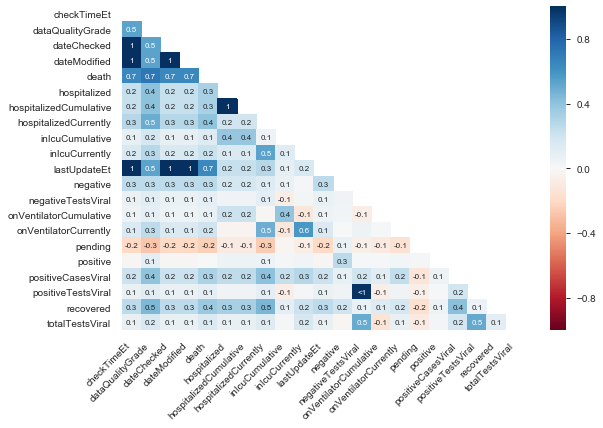

In [67]:
report  = ProfileReport(states_daily)


## NOTES: COLUMNS TO PLOT

- Basic Stats:
    - death: cumulative total people died
    - positive: total number people positive so far
    - negative
    - recovered
    

- Hospitalization:
    - hospitalizedCumulative: total number hospital so far(recovered and dead)
    - hospitalizedCurrently: 
    - hospitalizedIncrease


- ICU:
    - inIcuCumulative: total number hospital so far(recovered and dead)
    - inIcuCurrently: 
    
- Ventilator 
    - onVentilatorCumulative
    - onVentilatorCurrently


In [ ]:
NY = states_daily.groupby('state').get_group('NY')[DATA.state_columns_of_interest]#.plot(subplots=True,figsize=(20,60));
NY

In [ ]:
columns_of_interest = DATA.state_columns_of_interest#['total','positive','negative','death','recovered','hospitalized',
#                        'hospitalizedCurrently','hospitalizedCumulative',
#                        'inIcuCurrently','inIcuCumulative',
#                        'onVentilatorCurrently','onVentilatorCumulative']
NY

# 🗺Adding Mapping

## Geocoding

In [ ]:
df = corona.df_us
df

In [ ]:
# !pip install geopandas
# !pip install geopy

In [ ]:
from geopy.geocoders import Nominatim
locator = Nominatim(user_agent="myGeocoder")
res = locator.geocode('Baltimore')
res.latitude,res.longitude

## Folium

In [ ]:
# import folium
# center = (res.latitude,res.longitude) #(resp['region']['center']['latitude'],resp['region']['center']['longitude'])

# popup = folium.Popup(f"Latitude={center[0]}, Longitude={center[1]}")
# marker = folium.Marker(center,popup)
# mymap = folium.Map(center)
# marker.add_to(mymap)
# mymap